<a href="https://colab.research.google.com/github/amanjaiswal777/Sentiment_Analysis/blob/main/bert_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#Installing the huggingface library
!pip install transformers==2.8.0

     |████████████████████████████████| 573kB 11.0MB/s 
     |████████████████████████████████| 5.6MB 23.8MB/s 
     |████████████████████████████████| 1.2MB 33.8MB/s 
     |████████████████████████████████| 133kB 36.8MB/s 
     |████████████████████████████████| 901kB 23.5MB/s 
     |████████████████████████████████| 7.5MB 30.0MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 
ERROR: botocore 1.20.71 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
from transformers import AutoTokenizer, AutoModel
import seaborn as sns
from multiprocessing import Pool
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import multiprocessing
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import config

In [4]:
path = Path('')
assert path.exists()

In [5]:
!ls {path}

balanced_simplified_reviews_full.pkl  config.py  __pycache__  sample_data


In [6]:
balanced_simplified_reviews = pd.read_pickle(path/'balanced_simplified_reviews_full.pkl')

In [7]:
balanced_simplified_reviews['stars'] = balanced_simplified_reviews['stars'] - 1
balanced_simplified_reviews

,text,stars
2,I've stayed at many Marriott and Renaissance M...,1
5,"The setting is perfectly adequate, and the foo...",1
10,Disappointing. Bolt is a follow up of Fanny's ...,1
25,"When we first arrived at the Coco Key, we were...",1
40,"I wanted this to be a great place, but I wasn'...",1
...,...,...
9995,This is a really cool place that has a lot of ...,3
9996,"I thought this place would be good because, on...",3
9997,Coast is one of my go-to Happy Hour joints. T...,3
9998,I love that their pearls are made in house. Th...,4


### Prepare tokenizer and data loaders

In [8]:
NUM_CLASSES = len(balanced_simplified_reviews['stars'].unique())

In [9]:
tokenizer = AutoTokenizer.from_pretrained(config.PRE_TRAINED_MODEL_NAME)

In [10]:
def parallelize_dataframe(df, func, n_cores=8):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [11]:
def count_tokens(df):
    df['text_len'] = df['text'].apply(lambda t : len(tokenizer.encode(t, max_length=config.MAX_LENGTH)))
    return df

In [12]:
%%time

balanced_simplified_reviews = parallelize_dataframe(balanced_simplified_reviews, count_tokens, 10)

CPU times: user 113 ms, sys: 86.8 ms, total: 199 ms
Wall time: 10.1 s


Checking the distribution of the length of tokens

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


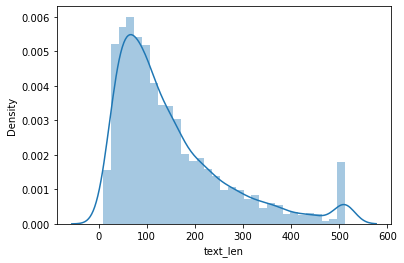

In [13]:
sns.distplot(balanced_simplified_reviews['text_len'])

In [14]:
class YelpDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews, self.targets,  self.tokenizer, self.max_len = reviews.to_numpy(), targets.to_numpy(), tokenizer, max_len
        
    def __len__(self):
        return len(self.reviews)
        
    def __getitem__(self, item):
        review = self.reviews[item]
        tokens = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'review': review,
            'input_ids': tokens['input_ids'].flatten(),
            'attention_mask': tokens['attention_mask'].flatten(),
            'target': torch.tensor(self.targets[item]).long()
        }

In [15]:
RANDOM_SEED = 42

def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [16]:
train_df, test_df = train_test_split(balanced_simplified_reviews, test_size=0.1, random_state=RANDOM_SEED, 
                                     stratify=balanced_simplified_reviews.stars.values)
valid_df, test_df = train_test_split(test_df, test_size=0.5, random_state=RANDOM_SEED, stratify=test_df.stars.values)
train_df.shape, test_df.shape, valid_df.shape

((3861, 3), (215, 3), (215, 3))

Checking if the distribution is even. We used `stratify` so it should be.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


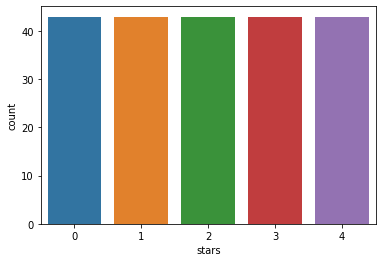

In [17]:
sns.countplot(valid_df['stars'])

In [18]:
def create_data_loader(df, tokenizer, max_length, batch_size):
    ds = YelpDataset(df['text'], df['stars'], tokenizer, max_length)
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=multiprocessing.cpu_count() - 1
    )

In [19]:
BATCH_SIZE=16

train_dl = create_data_loader(train_df, tokenizer, config.MAX_LENGTH, BATCH_SIZE)
test_dl = create_data_loader(test_df, tokenizer, config.MAX_LENGTH, BATCH_SIZE)
valid_dl = create_data_loader(valid_df, tokenizer, config.MAX_LENGTH, BATCH_SIZE)

In [20]:
sample_record = next(iter(train_dl))
sample_record['input_ids'][0]

tensor([  101,  1188,  1282,  1110,  1632,   119,  1109,  1160,  9834,  1116,
         1132,   170,  2337,  1105,  1152,  1815, 21620,  1193,  1107,  1103,
         3119,  1487,   119,  1135,   112,   188,  1176,  1152,  1132,  1543,
         1893,  1229,  1152,  9834,   119,  1220,  1138,   170,  2951,  1115,
         1867,  4268,  1129,  5351,  1112,  1195,  1294,  1155,  2094,  4489,
         1121, 14515,   119,  1135,  1108, 13108,  1105,  1103,  1436,  1497,
        17458,  1213,   106,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [21]:
sample_record['attention_mask'][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Prepare training

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [23]:
model = BertForSequenceClassification.from_pretrained(config.PRE_TRAINED_MODEL_NAME, num_labels = NUM_CLASSES, 
                                                      output_attentions = False, output_hidden_states = False)
model = model.to(device)

In [24]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-3},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [25]:
len([p for n, p in param_optimizer if not any(nd in n for nd in no_decay)]), len([p for n, p in param_optimizer if any(nd in n for nd in no_decay)])

(77, 124)

In [26]:
# AdamW Adam algorithm with weight decay fix
optimizer = AdamW(optimizer_parameters, 
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                 )

In [27]:
EPOCHS = 3

total_steps = len(train_dl) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [28]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [29]:
import os
import shutil
import pickle

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

def save_model(model, tokenizer, output_dir = path/'model_save'):

    # Create output directory if needed
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    else:
        shutil.rmtree(output_dir)
        os.makedirs(output_dir)

    print(f"Saving model to {output_dir}")

    tokenizer.save_pretrained(output_dir)
    torch.save(model, output_dir/'model')

### Training Loop

In [30]:
def grab_batch_data(batch):
    input_ids = batch['input_ids'].to(device)
    input_mask = batch['attention_mask'].to(device)
    labels = batch['target'].to(device)
    return input_ids, input_mask, labels

def eval_fn():
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    # Evaluate data for one epoch
    for batch in tqdm(valid_dl, total=len(valid_dl)):
        input_ids, input_mask, labels = grab_batch_data(batch)
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            (loss, logits) = model(input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=input_mask,
                                   labels=labels)
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            
    avg_val_accuracy = total_eval_accuracy / len(valid_dl)
    avg_val_loss = total_eval_loss / len(valid_dl)
    print(f"  Accuracy: {avg_val_accuracy:.2f}")
    print(f"  Validation Loss: {avg_val_loss:.2f}")
    return {
        'Accuracy': avg_val_accuracy,
        'Validation Loss': avg_val_loss
    }

In [31]:
training_stats = []
best_accuracy = 0
for epoch in tqdm(range(0, EPOCHS), total=EPOCHS):
    total_train_loss = 0
    model.train()
    for step, batch in tqdm(enumerate(train_dl), total=len(train_dl)):
        input_ids, input_mask, labels = grab_batch_data(batch)
        model.zero_grad()  
        loss, logits = model(input_ids, 
                             token_type_ids=None, 
                             attention_mask=input_mask, 
                             labels=labels)
        total_train_loss += loss.item()
        if step % 2000 == 0:
            print(f'{step}: Loss: {total_train_loss / (step + 1)}\r')
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_dl)
    print("")
    print(f"  Average training loss: {avg_train_loss}")
    stats_info = eval_fn()
    stats_info['epoch'], stats_info['Average training loss'] = epoch, avg_train_loss
    training_stats.append(stats_info)
    save_model(model, tokenizer, output_dir=path/f'output_dir_{epoch}')
    if stats_info['Accuracy'] > best_accuracy:
        save_model(model, tokenizer, output_dir=path/f'output_dir_best')
        best_accuracy = stats_info['Accuracy']

0: Loss: 1.6313046216964722


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)




  Average training loss: 1.182192459825642



  Accuracy: 0.52
  Validation Loss: 1.06
Saving model to output_dir_0
Saving model to output_dir_best


0: Loss: 0.817341685295105


  Average training loss: 0.8085454513957678



  Accuracy: 0.57
  Validation Loss: 1.03
Saving model to output_dir_1
Saving model to output_dir_best


0: Loss: 0.36941009759902954


  Average training loss: 0.6221446028548824



  Accuracy: 0.58
  Validation Loss: 0.96
Saving model to output_dir_2
Saving model to output_dir_best



In [32]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)
df_stats

,Accuracy,Validation Loss,epoch,Average training loss
0,0.521684,1.058245,0,1.182192
1,0.565051,1.032772,1,0.808545
2,0.580995,0.958572,2,0.622145


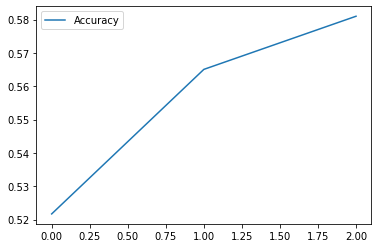

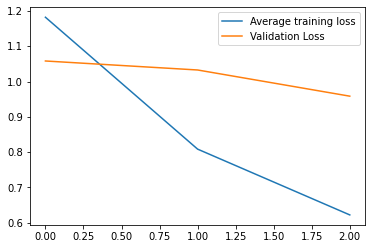

In [33]:
df_stats[['Accuracy']].plot(); df_stats[['Average training loss',  'Validation Loss']].plot()

In [34]:
input_ids, input_mask, labels = grab_batch_data(next(iter(valid_dl)))

In [35]:
loss, logits = model(input_ids, 
                             token_type_ids=None, 
                             attention_mask=input_mask, 
                             labels=labels)

In [36]:
import torch
from pathlib import Path
from transformers import AutoTokenizer
import numpy as np
import torch
import config

In [37]:
path = Path('output_dir_best')
assert path.exists()

In [38]:
!ls {path}

model  special_tokens_map.json	tokenizer_config.json  vocab.txt


In [39]:
def load_model():
    model = torch.load(path/'model')
    model.cpu()
    model.eval();
    return model

In [40]:
tokenizer = AutoTokenizer.from_pretrained(config.PRE_TRAINED_MODEL_NAME)
model = load_model()

In [41]:
def encode(sequence):
    return tokenizer.encode_plus(
                sequence,
                add_special_tokens=True,
                max_length=512,
                return_token_type_ids=False,
                pad_to_max_length=True,
                return_attention_mask=True,
                return_tensors='pt'
    )

In [42]:
def predict(sequence='I love you a lot. You are really great. You are wonderful and awesome.'):
    encoded = encode(sequence)
    with torch.no_grad():
        output = model(encoded['input_ids'].cpu(), token_type_ids=None, attention_mask=encoded['attention_mask'].cpu())[0]
        pred_flat = np.argmax(output, axis=1).flatten()
        sig_factor = torch.sigmoid(output) / torch.sigmoid(output).sum()
        return {'proportional':  sig_factor.numpy().tolist(), 'sigmoid': torch.sigmoid(output).numpy().tolist(), 'stars': pred_flat.item() + 1, 'raw': output.numpy().tolist()}

In [43]:
predict()

{'proportional': [[0.05952750891447067,
   0.061076387763023376,
   0.12388353794813156,
   0.33066269755363464,
   0.42484983801841736]],
 'raw': [[-1.8395808935165405,
   -1.8097515106201172,
   -0.9182109832763672,
   1.1612855195999146,
   3.817657947540283]],
 'sigmoid': [[0.13710086047649384,
   0.14066816866397858,
   0.28532254695892334,
   0.7615662217140198,
   0.9784935116767883]],
 'stars': 5}

In [44]:
predict('This is really terrible. Just avoid it')

{'proportional': [[0.37398967146873474,
   0.25595301389694214,
   0.16587179899215698,
   0.08564972132444382,
   0.1185358539223671]],
 'raw': [[2.5070409774780273,
   0.5442728400230408,
   -0.36357933282852173,
   -1.3143717050552368,
   -0.8805572390556335]],
 'sigmoid': [[0.9246339201927185,
   0.6328058242797852,
   0.41009339690208435,
   0.21175622940063477,
   0.293062299489975]],
 'stars': 1}

In [46]:
predict("We had a delicious mahi mahi steak for lunch while enjoying a terrific view of Pickering wharf and Salem Harbor. Our friends had the special catfish taco and the Baja taco off the regular menu, both of which got good reviews. The Baja taco needed a little Tabasco, but the fish was lightly battered and topped with fresh guac, tomatoes and cheese.\n\nThe mahi steaks were cooked well and the accompanying coconut rice and pineapple salsa were nice compliments. I had the cactus pear margarita, which was delicious despite it's off-putting radioactive purple color.")

{'proportional': [[0.01894202269613743,
   0.05658372491598129,
   0.28723981976509094,
   0.37528082728385925,
   0.2619536221027374]],
 'raw': [[-2.992091655731201,
   -1.7927007675170898,
   0.9674482345581055,
   2.8772177696228027,
   0.6669588088989258]],
 'sigmoid': [[0.04778442531824112,
   0.14274191856384277,
   0.7246105670928955,
   0.9467087388038635,
   0.6608218550682068]],
 'stars': 4}

In [47]:
predict("The best blacken jumbo shrimp tacos around. I highly recommend you give these a try. The fried catfish tacos are also good. Squeezing some fresh lime juice on each taco (you get 2) before you take your first bites really brings out the flavor in the fish coating. So much flavor, juicy and fresh. I like mines with lettuce, tomato and the cilantro ranch dressing on the side for dippin'. Pairs very well with a side of perfectly seasoned cilantro fries. Since moving to Austin  7 weeks ago, I've been the Lavaca about one a week.\n\nMy only complaint are the flies. I suggest management place fly traps around the restaurant. We've moved tables on several occasions because of the swarm of flies around one area.")

{'proportional': [[0.022280294448137283,
   0.034835923463106155,
   0.18767327070236206,
   0.38401275873184204,
   0.37119778990745544]],
 'raw': [[-2.8385088443756104,
   -2.358032703399658,
   -0.13771572709083557,
   3.00394344329834,
   2.4554286003112793]],
 'sigmoid': [[0.05527836084365845,
   0.0864294096827507,
   0.4656253755092621,
   0.9527519941329956,
   0.9209575057029724]],
 'stars': 4}